# Computational Astrophysics 23-24
## Project track: Collisionless N-body simulations 
### Project-3: Tidal disruptions of a Plummer model 

## I Miloncini 

| Last Name | First Name | Student Number |
|-----------|------------|----------------|
|Bertinelli |Gabriele    |2103359         |
|Bonato     |Diego       |2091250         |
|Di Prima   |Giacomo     |2086992         |
|Viterbo    |Giuseppe    |2086516         |

### Import modules

In [1]:
%matplotlib inline

import numpy as np
import numpy.typing as npt
from matplotlib import pyplot as plt, animation as animation, ticker as mticker
from matplotlib.pyplot import cm
import pandas as pd
from tqdm.notebook import tqdm

from fireworks.particles import Particles
import fireworks.nbodylib.nunits as NU
import fireworks.nbodylib.potentials as fnp
import fireworks.nbodylib.dynamics as fnd
import fireworks.nbodylib.integrators as fni
import fireworks.ic as ic

### Simulation

In [ ]:
def softening(N: int, initial_position: float, M_G: float, eccentricity: float) -> float:

    """
    This function calculates the softening length for the PointMass potential.  
    The softening length is calculated as the mean distance between the stars.  

    Parameters
    ----------
    N : int
        Number of stars in the cluster
    
    initial_position : float
        Initial position along the x direction

    M_G : float
        Mass of the galaxy
    
    eccentricity : float
        Eccentricity of the orbit

    Returns
    -------
    float
        Softening length for the PointMass potential

    """

    # Load data from CSV file
    path = './Data/Plummer_Nbody_virial_' + str(N) + '.csv'
    data = pd.read_csv(path).values

    # Create Particles object
    particles = Particles(position=data[:, 1:4], velocity=data[:, 4:], mass=data[:, 0])

    # Move the stars to the frame of reference of the center of mass
    particles.pos -= particles.com_pos()
    particles.vel -= particles.com_vel()

    # Move the stars to the initial position
    particles.pos[:, 0] += initial_position * np.ones(len(particles))  # Move center of mass to x=initial_position, y=z=0

    # Calculate the velocity of the cluster based on the eccentricity of the orbit
    two_body = ic.ic_two_body(M_G, 1, initial_position, e=eccentricity)
    vel_cluster = two_body.vel[1,1]

    # Update vel along y direction based on eccentricity
    particles.vel[:, 1] += vel_cluster

    # calculate the mean distance between the stars to use as the softening length
    mean_distance = np.zeros((N, N)) 
    for i in range(2):
        mean_distance += (particles.pos[:, i] - particles.pos[:, i].reshape(N, 1))**2
    mean_distance = (np.sqrt(mean_distance[mean_distance != 0.0])).mean()

    return mean_distance


def orbit_integration(N: int, initial_position: float, M_G: float, eccentricity: float, potential: fnp, tstep: float = 0.01, N_orbit: float = 2) -> None:

    """
    This function integrates the orbit of a cluster of N stars around a PointMass potential for N_orbit orbits.  
    The function moves the stars in the frame of reference of the center of mass (CoM) and then moves the stars 
    to the initial position along the x direction.  
    The function calculates the velocity of the cluster based on the eccentricity of the orbit and updates the velocity
    of the stars along the y direction.  

    The function saves the position, velocity, mass and energy of the cluster in the frame of reference of the galaxy and
    in the frame of reference of the CoM.

    Parameters
    ----------
    N : int
        Number of stars in the cluster
    
    initial_position : float
        Initial position along the x direction
    
    M_G : float
        Mass of the galaxy
    
    eccentricity : float
        Eccentricity of the orbit

    potential : fireworks.nbodylib.potentials
        Potential to be used in the integration

    tstep : float. Default = 0.01
        Time step for integration

    N_orbit : float. Default = 2
        Number of orbits to integrate

    """

    # Load data from CSV file
    path = './Data/Plummer_Nbody_virial_' + str(N) + '.csv'

    data = pd.read_csv(path).values

    # Create Particles object
    particles = Particles(position=data[:, 1:4], velocity=data[:, 4:], mass=data[:, 0])

    # Move the stars to the frame of reference of the center of mass
    particles.pos -= particles.com_pos()
    particles.vel -= particles.com_vel()

    # Move the stars to the initial position
    particles.pos[:, 0] += initial_position * np.ones(len(particles))  # Move center of mass to x=initial_position/2, y=z=0

    # Calculate the velocity of the cluster based on the eccentricity of the orbit
    two_body = ic.ic_two_body(M_G, 1, initial_position, e=eccentricity)
    vel_cluster = two_body.vel[1,1]

    # Update vel along y direction based on eccentricity
    particles.vel[:, 1] += vel_cluster

    # # calculate the mean distance between the stars to use as the softening length
    # mean_distance = np.zeros((N, N)) 
    # for i in range(2):
    #     mean_distance += (particles.pos[:, i] - particles.pos[:, i].reshape(N, 1))**2
    # mean_distance = (np.sqrt(mean_distance[mean_distance != 0.0])).mean()

    # # Create the PointMass potential
    # potential_PointMass = fnp.Point_Mass(Mass=M_G, softening = mean_distance) 

    # # Additional potentials
    # # potential_Plummer = fnp.Plummer(Mass=1, a=0.59) 

    # # potential_tot = fnp.MultiPotential([potential_PointMass, potential_Plummer])

    # total time of integration
    orbital_period = 2*np.pi*np.sqrt(np.sqrt(initial_position**2/(1-eccentricity**2))**3 /M_G) #orbital period 
    time = np.arange(0, N_orbit*orbital_period, tstep)

    # Initial total energy
    E_tot0, _, _ = particles.Etot()

    # list for analysis
    pos_list, pos_com_list, vel_list, vel_com_list, energy_list, pot_list = [particles.pos], [particles.com_pos()], [particles.vel], [particles.com_vel()], [E_tot0], []

    # integrate the system
    for dt in tqdm(time):

        acc_PointMass = potential.acceleration
        particles, _, _, _, pot = fni.integrator_leapfrog(particles=particles, tstep=tstep, 
                                                        acceleration_estimator=fnd.acceleration_pyfalcon, 
                                                        external_accelerations=[potential.acceleration])
        
        #saving important quantities for analysis of the dynamics
        pos_list.append(particles.pos.copy())
        pos_com_list.append(particles.com_pos())
        vel_list.append(particles.vel.copy())
        vel_com_list.append(particles.com_vel())
        
        Etot, _, _ = particles.Etot()
        energy_list.append(Etot)
        pot_list.append(pot)

    # Convert to numpy arrays  
    pos_array = np.array(pos_list)
    pos_com_array = np.array(pos_com_list)
    vel_array = np.array(vel_list)
    vel_com_array = np.array(vel_com_list)
    energy_array = np.array(energy_list)
    pot_array = np.array(pot_list)

    # Save arrays to npy file
    array_to_save = np.zeros((len(pos_array), N, 9))

    array_to_save[:, :, :3], array_to_save[:, :, 3:6], array_to_save[:, :, 6], array_to_save[:, 0, 7] = pos_array, vel_array, (1/N)*np.ones_like(array_to_save[:, :, 6]), energy_array
    array_to_save[0, :, 8] = pot_array[0, :]#.reshape(1, N).shape

    array_to_save[1:, :, 8] = pot_array

    np.save(file=f'Orbit/Galactic_FoR/{N}_InitialPos_{initial_position}_e_{eccentricity}_t_{tstep}_FORGIF.npy', arr=array_to_save)

    # Shift in the frame of reference of CoM and save
    position_comFoR = np.ones_like(pos_array)
    velocity_comFoR = np.ones_like(vel_array)

    for i in range(len(pos_com_array)): #for every Snapshot
        for j in range(3):              #for x, y, z
            position_comFoR[i][:, j] = pos_array[i][:, j] - pos_com_array[i, j] #probably it can be done with numpy array brodcast           
            velocity_comFoR[i][:, j] = vel_array[i][:, j] - vel_com_array[i, j] #probably it can be done with numpy array brodcast 

    # with broadcast  
    # position_comFoR = pos_array - pos_com_array[:, None]
    # velocity_comFoR = vel_array - vel_com_array[:, None]    

    #save the com Frame of reference
    array_to_save = np.zeros((len(position_comFoR), N, 9))

    # pos, vel, mass, energy
    array_to_save[:, :, :3], array_to_save[:, :, 3:6], array_to_save[:, :, 6], array_to_save[:, 0, 7] = position_comFoR, velocity_comFoR, (1/N)*np.ones_like(array_to_save[:, :, 6]), energy_array
    array_to_save[0, :, 8] = pot_array[0, :]#.reshape(1, N).shape

    array_to_save[1:, :, 8] = pot_array

    # np.save(file=f'Orbit/Cluster_FoR/{N}_InitialPos_{initial_position}_e_{eccentricity}_t_{tstep}', arr=array_to_save)

In [ ]:
N = 1000                # Number of stars in the cluster
initial_position = 10   # Initial position along x direction 
M_G = 1e3               # Mass of the galaxy
eccentricity = 0.0    # Eccentricity of the orbit
tstep = 0.01        # Time step for integration
N_orbit = 5.0        # Number of orbits to integrate

mean_distance = softening(N, initial_position, M_G, eccentricity)

# Create the PointMass potential
potential_PointMass = fnp.Point_Mass(Mass=M_G, softening = mean_distance)

orbit_integration(N, initial_position, M_G, eccentricity, potential_PointMass, tstep, N_orbit)

### GIF generation for visual inspection of the integration

In [2]:
def flag_cluster(position: npt.NDArray[np.float64], mass: npt.NDArray[np.float64], N: int, M_G: float):
    
    """
    Function to find the stars that are bound to the cluster. Create a flag array with the same length as the number of stars
    in the cluster. The flag array is set to True for the stars that are bound to the cluster and False for the stars that are
    unbound. The function returns the flag array, the center of mass of the cluster and the tidal radius of the cluster.

    Parameters
    ----------
    position : npt.NDArray[np.float64]
        Array with the positions of the stars at each snapshot

    velocity : npt.NDArray[np.float64]
        Array with the velocities of the stars at each snapshot

    mass : npt.NDArray[np.float64]
        Array with the mass of the stars at each snapshot

    N : int
        Number of stars in the cluster

    M_G : float
        Mass of the galaxy
    """

    flag_history = []
    com_history = []
    tidal2_history = []

    flag = np.ones(N, dtype=bool)
    for snapshot in tqdm(range(len(position))):
        pos_snap = position[snapshot]

        current_flag = np.zeros(N, dtype=bool)
        k = 0
        while flag.sum() - current_flag.sum() != 0:
            if k>100:
                break
            current_flag = flag.copy()
            if mass[snapshot][flag].sum() == 0:
                pos_com_snap = np.average(pos_snap[flag], axis=0)
            else:
                pos_com_snap = np.average(pos_snap[flag], axis=0, weights=mass[snapshot][flag])


            # Calculate distances to the center of mass
            distances_to_com = np.sqrt(np.sum((pos_snap - pos_com_snap)**2, axis=1))

            # Calculate tidal radius
            r_t = np.linalg.norm(pos_com_snap) * (np.sum(mass[snapshot][flag]) / M_G) ** (1 / 3)

            # Update flag based on tidal radius
            flag = distances_to_com < 2*r_t

        flag_history.append(flag)
        com_history.append(pos_com_snap)
        tidal2_history.append(2*r_t)

    return flag_history, com_history, tidal2_history


In [4]:
def plot_orbit(N: int, initial_position: float, eccentricity: float, tstep: float, m: int) -> None:

    """
    This function plots the orbit of a cluster of N stars around a central potential.  
    The function loads the position of the stars and the center of mass from the npy file and plots the orbit.

    Parameters
    ----------
    N : int
        Number of stars in the cluster
    
    initial_position : float
        Initial position along the x direction

    eccentricity : float
        Eccentricity of the orbit

    tstep : float
        Time step for integration

    m : int
        Downsampling factor for the animation
    """

    data = np.load(f'Orbit/Galactic_FoR/{N}_InitialPos_{initial_position}_e_{eccentricity}_t_{tstep}_FORGIF.npy', allow_pickle=True)
    pos_array = data[:1100, :, :3]
    mass = 1/N * np.ones((len(pos_array), N))

    # data_c = np.load(f'Orbit/Cluster_FoR/{N}_InitialPos_{initial_position}_e_{eccentricity}_t_{tstep}.npy', allow_pickle=True)
    # pos_com_array = data_c[:, :, :3]

    

    pos_array_plot = pos_array.copy()[::m] #the copy is useful to not overwrite pos_array (otherwise you would need to rerun the integration, we don't want that)
    # pos_com_array_plot = pos_com_array.copy()[::m]

    flag_history, pos_com_array_plot, tidal2_history = flag_cluster(pos_array, mass=mass, N=N, M_G=1e3)
    flag_history, pos_com_array_plot, tidal2_history = flag_history[::m], pos_com_array_plot[::m], tidal2_history[::m]
    

    fig = plt.figure(figsize=(8,8), layout='tight')
    ax = fig.add_subplot(projection='3d', computed_zorder=False)
    plt.rcParams['font.size'] = '16'
    plt.rcParams['lines.linewidth'] = '4'
    plt.rcParams['axes.titlesize'] = '15'
    plt.rcParams['axes.titlepad'] = '10'
    plt.rcParams['axes.labelsize'] = '12'
    plt.rcParams['legend.fontsize'] = '10'
    plt.rcParams['axes.labelpad'] = '12'
    plt.rcParams['axes.titleweight'] = '600'
    plt.rcParams['axes.labelweight'] = '500'
    plt.rcParams['xtick.labelsize'] = '10'
    plt.rcParams['ytick.labelsize'] = '10'
    plt.rcParams['xtick.major.size'] = '10'
    plt.rcParams['ytick.major.size'] = '10'
    plt.rcParams['ytick.minor.size'] = '4'

    # Calculate the number of extra frames to add at the beginning and the end
    pause_duration = 5  # pause duration in seconds start
    pause_duration_end = 1  # pause duration in seconds end
    frame_rate = 15  # frame rate of the animation
    extra_frames = pause_duration * frame_rate
    extra_frames_end = pause_duration_end * frame_rate

    # Create an array of frame indices
    frames = np.concatenate([
        np.full(int(extra_frames), 0),  # initial frame (pause
        np.arange(0, len(pos_array_plot[:])-1, 2),  # original frames
        np.full(int(extra_frames_end), len(pos_array_plot[:])-2)  # extra frames at the end
    ])

    indexes = np.arange(0, len(frames), 1)

    mask = flag_history[0]
    ax.scatter(pos_array_plot[0, :, 0][~mask], pos_array_plot[0, :, 1][~mask], pos_array_plot[0, :, 2][~mask], s=1, zorder=-1, alpha=0.5, label=r'R>$2r_t$')
    ax.scatter(pos_array_plot[0, :, 0][mask], pos_array_plot[0, :, 1][mask], pos_array_plot[0, :, 2][mask], s=1, zorder=-1, alpha=0.5, label=r'R<$2r_t$')

    ax.scatter(pos_array_plot[0].mean(axis=0)[0], pos_array_plot[0].mean(axis=0)[1], pos_array_plot[0].mean(axis=0)[2], s=100, marker='.', c='r', zorder=1, label='CoM')
    ax.scatter(pos_com_array_plot[0][0], pos_com_array_plot[0][1], pos_com_array_plot[0][2], s=100,  c='yellow', marker='*', edgecolor='k', label='Iterative CoM', zorder=1)
    ax.scatter(xs = 0, ys = 0, zs = 0, s=100, c='darkgreen', marker='X', label='Point Mass')
    ax.set_xlim(-initial_position, initial_position)
    ax.set_ylim(-initial_position, initial_position)
    ax.set_zlim(-initial_position, initial_position)
    ax.set_xlabel('X [Henon Units]')
    ax.set_ylabel('Y [Henon Units]')
    ax.set_zlabel('Z [Henon Units]')
    ax.set_title(f'{N} stars, e: {eccentricity}')
    ax.legend(loc='upper left')
    fig.subplots_adjust(top=1.1, bottom=-.1)


    def update_pos(frame): 
        ax.clear()
        mask = flag_history[frame]
        ax.scatter(pos_array_plot[frame, :, 0][~mask],pos_array_plot[frame, :, 1][~mask], pos_array_plot[frame, :, 2][~mask], s=1, zorder=-1, alpha=0.5, label=r'R>$2r_t$')
        ax.scatter(pos_array_plot[frame, :, 0][mask], pos_array_plot[frame, :, 1][mask], pos_array_plot[frame, :, 2][mask], s=1, zorder=-1, alpha=0.5, label=r'R<$2r_t$')
        ax.scatter(pos_array_plot[frame].mean(axis=0)[0], pos_array_plot[frame].mean(axis=0)[1], pos_array_plot[frame].mean(axis=0)[2], s=100, marker='.', c='r', zorder=1, label='CoM')
        ax.scatter(pos_com_array_plot[frame][0], pos_com_array_plot[frame][1], pos_com_array_plot[frame][2], s=100, c='yellow', marker='*', edgecolor='k', label='Iterative CoM', zorder=1)
        ax.scatter(xs = 0, ys = 0, zs = 0, s=100, c='darkgreen', marker='X', label='Point Mass')
        ax.set_xlim(-initial_position, initial_position)
        ax.set_ylim(-initial_position, initial_position)
        ax.set_zlim(-initial_position, initial_position)

        ax.set_xlabel('X [Henon Units]')
        ax.set_ylabel('Y [Henon Units]')
        ax.set_zlabel('Z [Henon Units]')
        ax.set_title(f'{N} stars, e: {eccentricity}, frame: {frame}/{frames.max()}')
        ax.legend(loc='upper left')
        
        fig.suptitle(f'Tidal distruption of Plummer sphere', 
                    fontsize=24, fontweight='600')
        fig.subplots_adjust(top=1.1, bottom=-.1)

    print(f"Starting Position Animation: {N}_InitialPos_{initial_position}_e_{eccentricity}_t_{tstep}.gif ")

    gif_pos = animation.FuncAnimation(fig=fig, func=update_pos, frames=frames, interval=10)
    gif_pos.save(f"./gif/Galaxy_FoR/{N}_InitialPos_{initial_position}_e_{eccentricity}_t_{tstep}.gif", writer="pillow")

    print(f"Position Animation Saved: {N}_InitialPos_{initial_position}_e_{eccentricity}_t_{tstep}.gif")

  0%|          | 0/1100 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/root/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Starting Position Animation: 1000_InitialPos_10_e_0.0_t_0.01.gif 
Position Animation Saved: 1000_InitialPos_10_e_0.0_t_0.01.gif


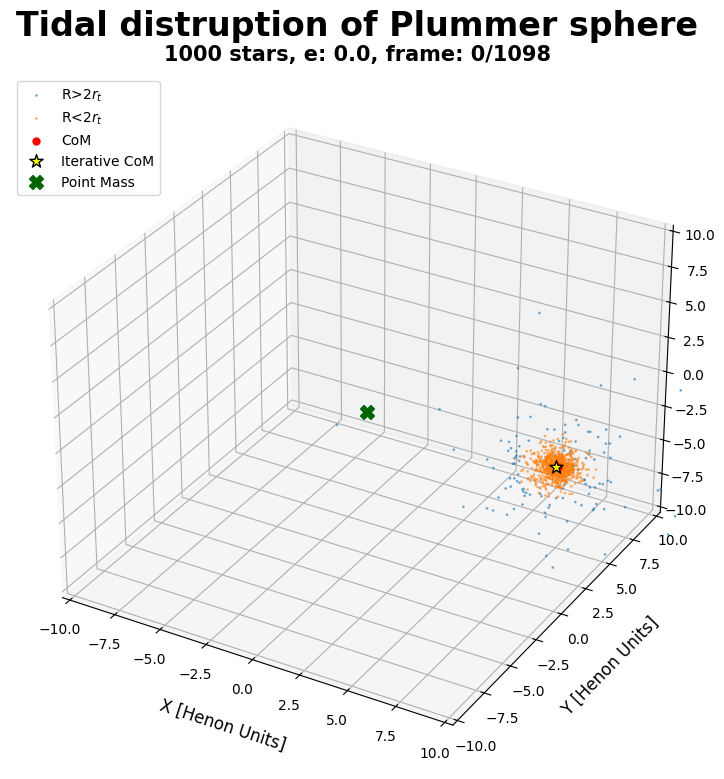

In [5]:
N = 1000                # Number of stars in the cluster
initial_position = 10   # Initial position along x direction 
M_G = 1e3               # Mass of the galaxy
eccentricity = 0.0    # Eccentricity of the orbit
tstep = 0.01        # Time step for integration
N_orbit = 2.5        # Number of orbits to integrate


plot_orbit(N, initial_position, eccentricity, tstep, m=1)

In [10]:
def plot_orbit(N: int, initial_position: float, eccentricity: float, tstep: float, m: int) -> None:

    """
    This function plots the orbit of a cluster of N stars around a central potential.  
    The function loads the position of the stars and the center of mass from the npy file and plots the orbit.

    Parameters
    ----------
    N : int
        Number of stars in the cluster
    
    initial_position : float
        Initial position along the x direction

    eccentricity : float
        Eccentricity of the orbit

    tstep : float
        Time step for integration

    m : int
        Downsampling factor for the animation
    """

    data = np.load(f'Orbit/Galactic_FoR/{N}_InitialPos_{initial_position}_e_{eccentricity}_t_{tstep}_FORGIF.npy', allow_pickle=True)
    pos_array = data[:2200, :, :3]
    mass = 1/N * np.ones((len(pos_array), N))

    # data_c = np.load(f'Orbit/Cluster_FoR/{N}_InitialPos_{initial_position}_e_{eccentricity}_t_{tstep}.npy', allow_pickle=True)
    # pos_com_array = data_c[:, :, :3]

    

    pos_array_plot = pos_array.copy()[::m] #the copy is useful to not overwrite pos_array (otherwise you would need to rerun the integration, we don't want that)
    # pos_com_array_plot = pos_com_array.copy()[::m]

    flag_history, pos_com_array_plot, tidal2_history = flag_cluster(pos_array, mass=mass, N=N, M_G=1e3)
    flag_history, pos_com_array_plot, tidal2_history = flag_history[::m], pos_com_array_plot[::m], tidal2_history[::m]
    

    fig = plt.figure(figsize=(8,8), layout='tight')
    ax = fig.add_subplot(projection='3d', computed_zorder=False)
    plt.rcParams['font.size'] = '16'
    plt.rcParams['lines.linewidth'] = '4'
    plt.rcParams['axes.titlesize'] = '15'
    plt.rcParams['axes.titlepad'] = '10'
    plt.rcParams['axes.labelsize'] = '12'
    plt.rcParams['legend.fontsize'] = '10'
    plt.rcParams['axes.labelpad'] = '12'
    plt.rcParams['axes.titleweight'] = '600'
    plt.rcParams['axes.labelweight'] = '500'
    plt.rcParams['xtick.labelsize'] = '10'
    plt.rcParams['ytick.labelsize'] = '10'
    plt.rcParams['xtick.major.size'] = '10'
    plt.rcParams['ytick.major.size'] = '10'
    plt.rcParams['ytick.minor.size'] = '4'

    # Calculate the number of extra frames to add at the beginning and the end
    pause_duration = 5  # pause duration in seconds start
    pause_duration_end = 1  # pause duration in seconds end
    frame_rate = 15  # frame rate of the animation
    extra_frames = pause_duration * frame_rate
    extra_frames_end = pause_duration_end * frame_rate

    # Create an array of frame indices
    frames = np.concatenate([
        np.full(int(extra_frames), 0),  # initial frame (pause
        np.arange(0, len(pos_array_plot[:])-1, 2),  # original frames
        np.full(int(extra_frames_end), len(pos_array_plot[:])-2)  # extra frames at the end
    ])

    indexes = np.arange(0, len(frames), 1)

    mask = flag_history[0]
    ax.scatter(pos_array_plot[0, :, 0][~mask], pos_array_plot[0, :, 1][~mask], pos_array_plot[0, :, 2][~mask], s=1, zorder=-1, alpha=0.5, label=r'R>$2r_t$')
    ax.scatter(pos_array_plot[0, :, 0][mask], pos_array_plot[0, :, 1][mask], pos_array_plot[0, :, 2][mask], s=1, zorder=-1, alpha=0.5, label=r'R<$2r_t$')

    ax.scatter(pos_array_plot[0].mean(axis=0)[0], pos_array_plot[0].mean(axis=0)[1], pos_array_plot[0].mean(axis=0)[2], s=100, marker='.', c='r', zorder=1, label='CoM')
    ax.scatter(pos_com_array_plot[0][0], pos_com_array_plot[0][1], pos_com_array_plot[0][2], s=100,  c='yellow', marker='*', edgecolor='k', label='Iterative CoM', zorder=1)
    ax.scatter(xs = 0, ys = 0, zs = 0, s=100, c='darkgreen', marker='X', label='Point Mass')
    ax.set_xlim(-3.2*initial_position, 1.2*initial_position)
    ax.set_ylim(-3.2*initial_position, 1.2*initial_position)
    ax.set_zlim(-3.2*initial_position, 1.2*initial_position)
    ax.set_xlabel('X [Henon Units]')
    ax.set_ylabel('Y [Henon Units]')
    ax.set_zlabel('Z [Henon Units]')
    ax.set_title(f'{N} stars, e: {eccentricity}')
    ax.legend(loc='upper left')
    fig.subplots_adjust(top=1.1, bottom=-.1)


    def update_pos(frame): 
        ax.clear()
        mask = flag_history[frame]
        ax.scatter(pos_array_plot[frame, :, 0][~mask],pos_array_plot[frame, :, 1][~mask], pos_array_plot[frame, :, 2][~mask], s=1, zorder=-1, alpha=0.5, label=r'R>$2r_t$')
        ax.scatter(pos_array_plot[frame, :, 0][mask], pos_array_plot[frame, :, 1][mask], pos_array_plot[frame, :, 2][mask], s=1, zorder=-1, alpha=0.5, label=r'R<$2r_t$')
        ax.scatter(pos_array_plot[frame].mean(axis=0)[0], pos_array_plot[frame].mean(axis=0)[1], pos_array_plot[frame].mean(axis=0)[2], s=100, marker='.', c='r', zorder=1, label='CoM')
        ax.scatter(pos_com_array_plot[frame][0], pos_com_array_plot[frame][1], pos_com_array_plot[frame][2], s=100, c='yellow', marker='*', edgecolor='k', label='Iterative CoM', zorder=1)
        ax.scatter(xs = 0, ys = 0, zs = 0, s=100, c='darkgreen', marker='X', label='Point Mass')
        ax.set_xlim(-3.2*initial_position, 1.2*initial_position)
        ax.set_ylim(-3.2*initial_position, 1.2*initial_position)
        ax.set_zlim(-3.2*initial_position, 1.2*initial_position)

        ax.set_xlabel('X [Henon Units]')
        ax.set_ylabel('Y [Henon Units]')
        ax.set_zlabel('Z [Henon Units]')
        ax.set_title(f'{N} stars, e: {eccentricity}, frame: {frame}/{frames.max()}')
        ax.legend(loc='upper left')
        
        fig.suptitle(f'Tidal distruption of Plummer sphere', 
                    fontsize=24, fontweight='600')
        fig.subplots_adjust(top=1.1, bottom=-.1)

    print(f"Starting Position Animation: {N}_InitialPos_{initial_position}_e_{eccentricity}_t_{tstep}.gif ")

    gif_pos = animation.FuncAnimation(fig=fig, func=update_pos, frames=frames, interval=10)
    gif_pos.save(f"./gif/Galaxy_FoR/{N}_InitialPos_{initial_position}_e_{eccentricity}_t_{tstep}.gif", writer="pillow")

    print(f"Position Animation Saved: {N}_InitialPos_{initial_position}_e_{eccentricity}_t_{tstep}.gif")

  0%|          | 0/2200 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/root/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Starting Position Animation: 1000_InitialPos_10_e_0.5_t_0.01.gif 
Position Animation Saved: 1000_InitialPos_10_e_0.5_t_0.01.gif


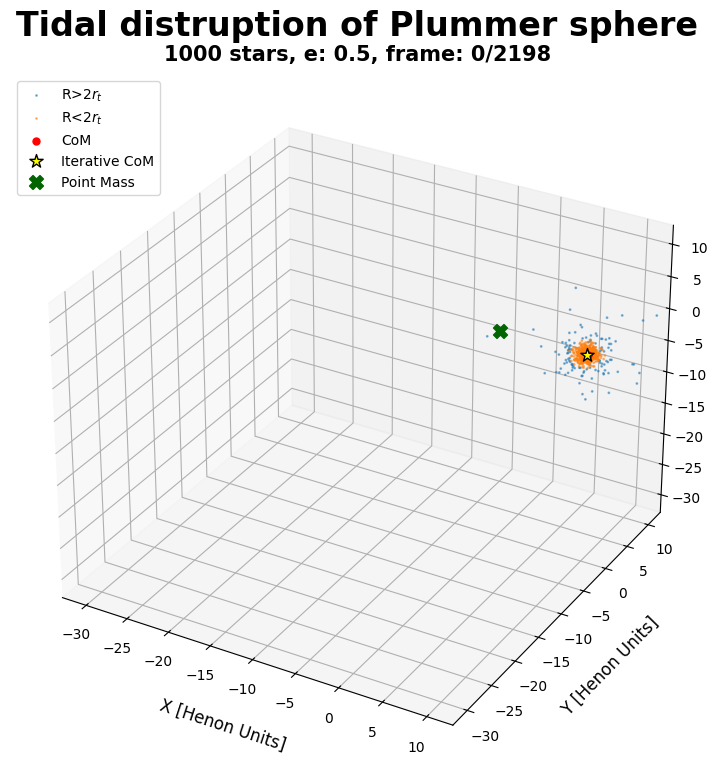

In [11]:
N = 1000                # Number of stars in the cluster
initial_position = 10   # Initial position along x direction 
M_G = 1e3               # Mass of the galaxy
eccentricity = 0.5    # Eccentricity of the orbit
tstep = 0.01        # Time step for integration
N_orbit = 2.5        # Number of orbits to integrate


plot_orbit(N, initial_position, eccentricity, tstep, m=1)